In [20]:
import warnings
# Set the warnings to be ignored
warnings.filterwarnings('ignore')

import os
import sys
import logging
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTENC
from scipy import stats

from ydata_profiling import ProfileReport
import seaborn as sns
import pickle

# EDA:

In [21]:
op1 = pd.read_csv("D:\Data-Science-D-drive\sensor_placement_LogisticRegression\data\sensor_placement\output_df.csv")

In [22]:
op1.head()

,Unnamed: 0,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Output
0,0,0,39.25,0.43,22.75,0.43,33.75,1.3,bending1
1,1,250,39.25,0.43,23.00,0.00,33.00,0.0,bending1
2,2,500,39.25,0.43,23.25,0.43,33.00,0.0,bending1
3,3,750,39.50,0.50,23.00,0.71,33.00,0.0,bending1
4,4,1000,39.50,0.50,24.00,0.00,33.00,0.0,bending1


In [23]:
op1.shape

(40799, 9)

In [24]:
df = pd.read_csv("D:\Data-Science-D-drive\sensor_placement_LogisticRegression\data\sensor_placement\output_df_final.csv",index_col=False)

In [25]:
df.shape

(40798, 8)

In [26]:
df["Output"].unique()

array(['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing',
       'walking'], dtype=object)

In [27]:
df.head()

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Output
0,0,39.25,0.43,22.75,0.43,33.75,1.3,bending1
1,250,39.25,0.43,23.00,0.00,33.00,0.0,bending1
2,500,39.25,0.43,23.25,0.43,33.00,0.0,bending1
3,750,39.50,0.50,23.00,0.71,33.00,0.0,bending1
4,1000,39.50,0.50,24.00,0.00,33.00,0.0,bending1


In [28]:
df.rename(columns={"# Columns: time":"Time"},inplace=True)

In [29]:
df1 = df.copy()

In [30]:
df1.head()

,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Output
0,0,39.25,0.43,22.75,0.43,33.75,1.3,bending1
1,250,39.25,0.43,23.00,0.00,33.00,0.0,bending1
2,500,39.25,0.43,23.25,0.43,33.00,0.0,bending1
3,750,39.50,0.50,23.00,0.71,33.00,0.0,bending1
4,1000,39.50,0.50,24.00,0.00,33.00,0.0,bending1


In [31]:
df1.isnull().sum()

Time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
Output       0
dtype: int64

In [32]:
#col_list = list(df1.columns)

#for i in col_list:
#    if df1[i].isna().sum() > 0:
#        df1[i].fillna(df1[i].median(),inplace=True)

#df1.isnull().sum()

In [33]:
# Checking for duplicated records
df1.duplicated().sum()

3359

In [34]:
duplicated_df = df1[df1.duplicated()]

In [35]:
duplicated_df.shape[0]/df1.shape[0]*100

8.233246727780774

In [36]:
profile = ProfileReport(df1)

In [37]:
#profile

In [38]:
df1.drop_duplicates(inplace=True)

In [39]:
df1.duplicated().sum()

0

In [40]:
df1.shape[0]

37439

In [41]:
df.shape

(40798, 8)

In [42]:
100-(df1.shape[0]/df.shape[0]*100)

8.23324672778078

We have lost 8.23% of the data after removing duplicates

In [43]:
for i in df1.columns:
    print(i,"---",df1[i].dtype)

Time --- int64
avg_rss12 --- float64
var_rss12 --- float64
avg_rss13 --- float64
var_rss13 --- float64
avg_rss23 --- float64
var_rss23 --- float64
Output --- object


In [44]:
numerical_columns = []
categorical_columns = []
for column in df1.columns:
    if df1[column].dtypes == "object":
        categorical_columns.append(column)
    else:
        numerical_columns.append(column)

In [45]:
numerical_columns

['Time',
 'avg_rss12',
 'var_rss12',
 'avg_rss13',
 'var_rss13',
 'avg_rss23',
 'var_rss23']

In [46]:
categorical_columns

['Output']

In [47]:
df1[categorical_columns].describe()

,Output
count,37439
unique,7
top,standing
freq,7200


In [48]:
df1[numerical_columns].describe()

,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
count,37439.000000,37439.000000,37439.000000,37439.000000,37439.000000,37439.000000,37439.000000
mean,59876.278747,38.998961,1.517531,14.694201,1.525591,16.506918,1.643804
std,34640.968701,6.220399,2.106981,5.205807,1.650437,6.682912,1.642632
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30000.000000,35.250000,0.430000,12.000000,0.430000,12.750000,0.470000
50%,60000.000000,40.000000,0.500000,15.000000,0.830000,16.250000,1.000000
75%,89875.000000,44.250000,2.050000,18.250000,2.380000,19.500000,2.380000
max,119750.000000,56.250000,17.240000,35.000000,11.420000,40.330000,13.610000


In [49]:
#ProfileReport(df1)

We would be removing zeros from var_rss as variance cannot be zero untill all readings of a sensor arent constant(which is not possible in real life).

In [50]:
df1 = df1.drop(df1.iloc[:, 1:-1][(df1.iloc[:, 1:-1] == 0).any(axis=1)].index)

In [51]:
#ProfileReport(df1)

<Axes: >

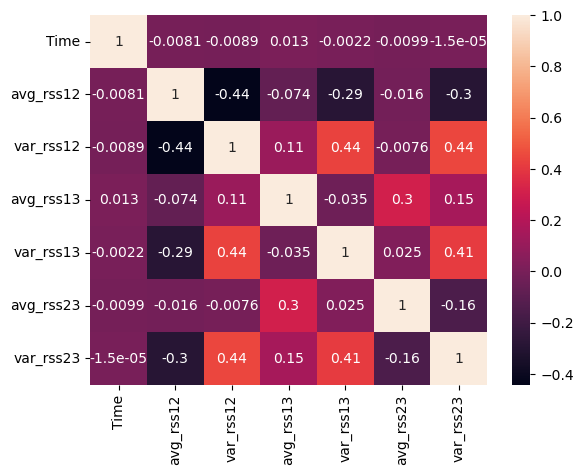

In [52]:
sns.heatmap(df1.corr(),annot=True)

# Label Encoding:

To find correlation matrix as it only works on numerical values.

In [53]:
label_encoder = LabelEncoder()
df1["Output"] = label_encoder.fit_transform(df1["Output"])
df1["Output"].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [54]:
df1.head()

,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Output
0,0,39.25,0.43,22.75,0.43,33.75,1.30,0
11,2750,39.50,0.50,23.50,0.50,32.75,0.43,0
12,3000,39.50,0.50,23.75,0.43,32.50,0.50,0
27,6750,40.50,0.50,19.75,1.09,33.75,1.30,0
30,7500,41.00,1.00,20.75,0.43,33.75,1.30,0


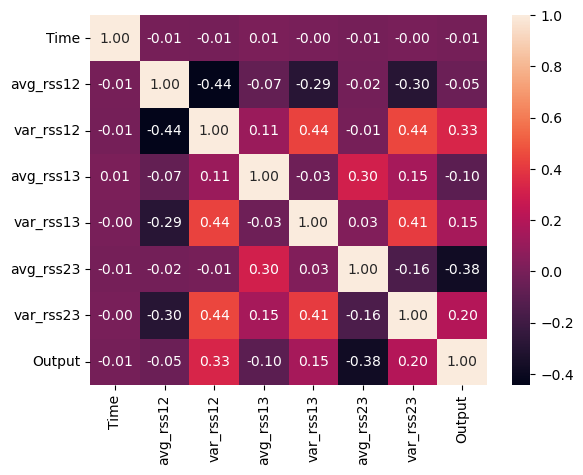

<Figure size 1000x800 with 0 Axes>

In [55]:
heatmap_size = (10, 8)  # Adjust the width and height as needed

sns.heatmap(df1.corr(), annot=True, fmt=".2f")
plt.figure(figsize=heatmap_size)  # Set the size of the figure
plt.show()

We can see there is no correlation between input columns

In [56]:
#df1["Output"] = label_encoder.inverse_transform(df1["Output"])

# Checking for Outliers:

In [57]:
df1.columns

Index(['Time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
       'var_rss23', 'Output'],
      dtype='object')

In [58]:
df1.head()

,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Output
0,0,39.25,0.43,22.75,0.43,33.75,1.30,0
11,2750,39.50,0.50,23.50,0.50,32.75,0.43,0
12,3000,39.50,0.50,23.75,0.43,32.50,0.50,0
27,6750,40.50,0.50,19.75,1.09,33.75,1.30,0
30,7500,41.00,1.00,20.75,0.43,33.75,1.30,0


In [59]:
df1.iloc[: ,1:7]

,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,39.25,0.43,22.75,0.43,33.75,1.30
11,39.50,0.50,23.50,0.50,32.75,0.43
12,39.50,0.50,23.75,0.43,32.50,0.50
27,40.50,0.50,19.75,1.09,33.75,1.30
30,41.00,1.00,20.75,0.43,33.75,1.30
...,...,...,...,...,...,...
40789,29.00,0.71,11.25,0.43,21.25,0.43
40791,28.67,0.47,11.00,1.00,19.33,1.25
40792,28.50,0.50,2.33,1.25,16.60,1.20
40793,28.67,0.47,4.67,1.25,17.33,0.47


<Axes: >

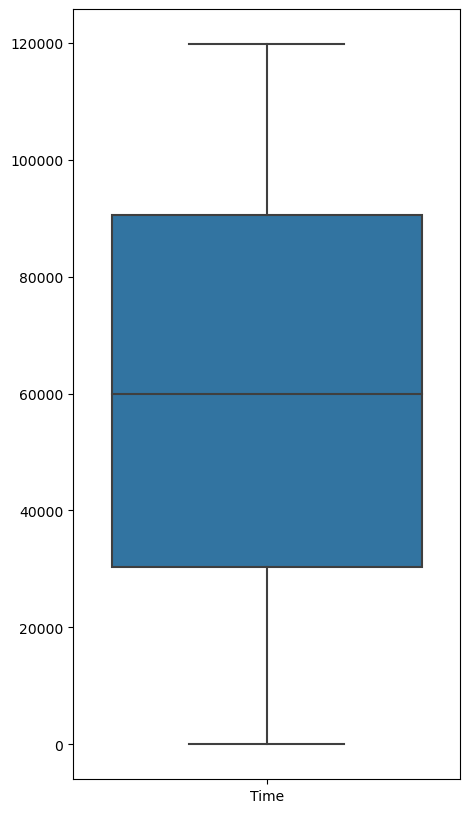

In [60]:
fig ,ax  = plt.subplots(figsize = (5,10))
sns.boxplot(data = df1.iloc[: ,:1], ax = ax)

<Axes: >

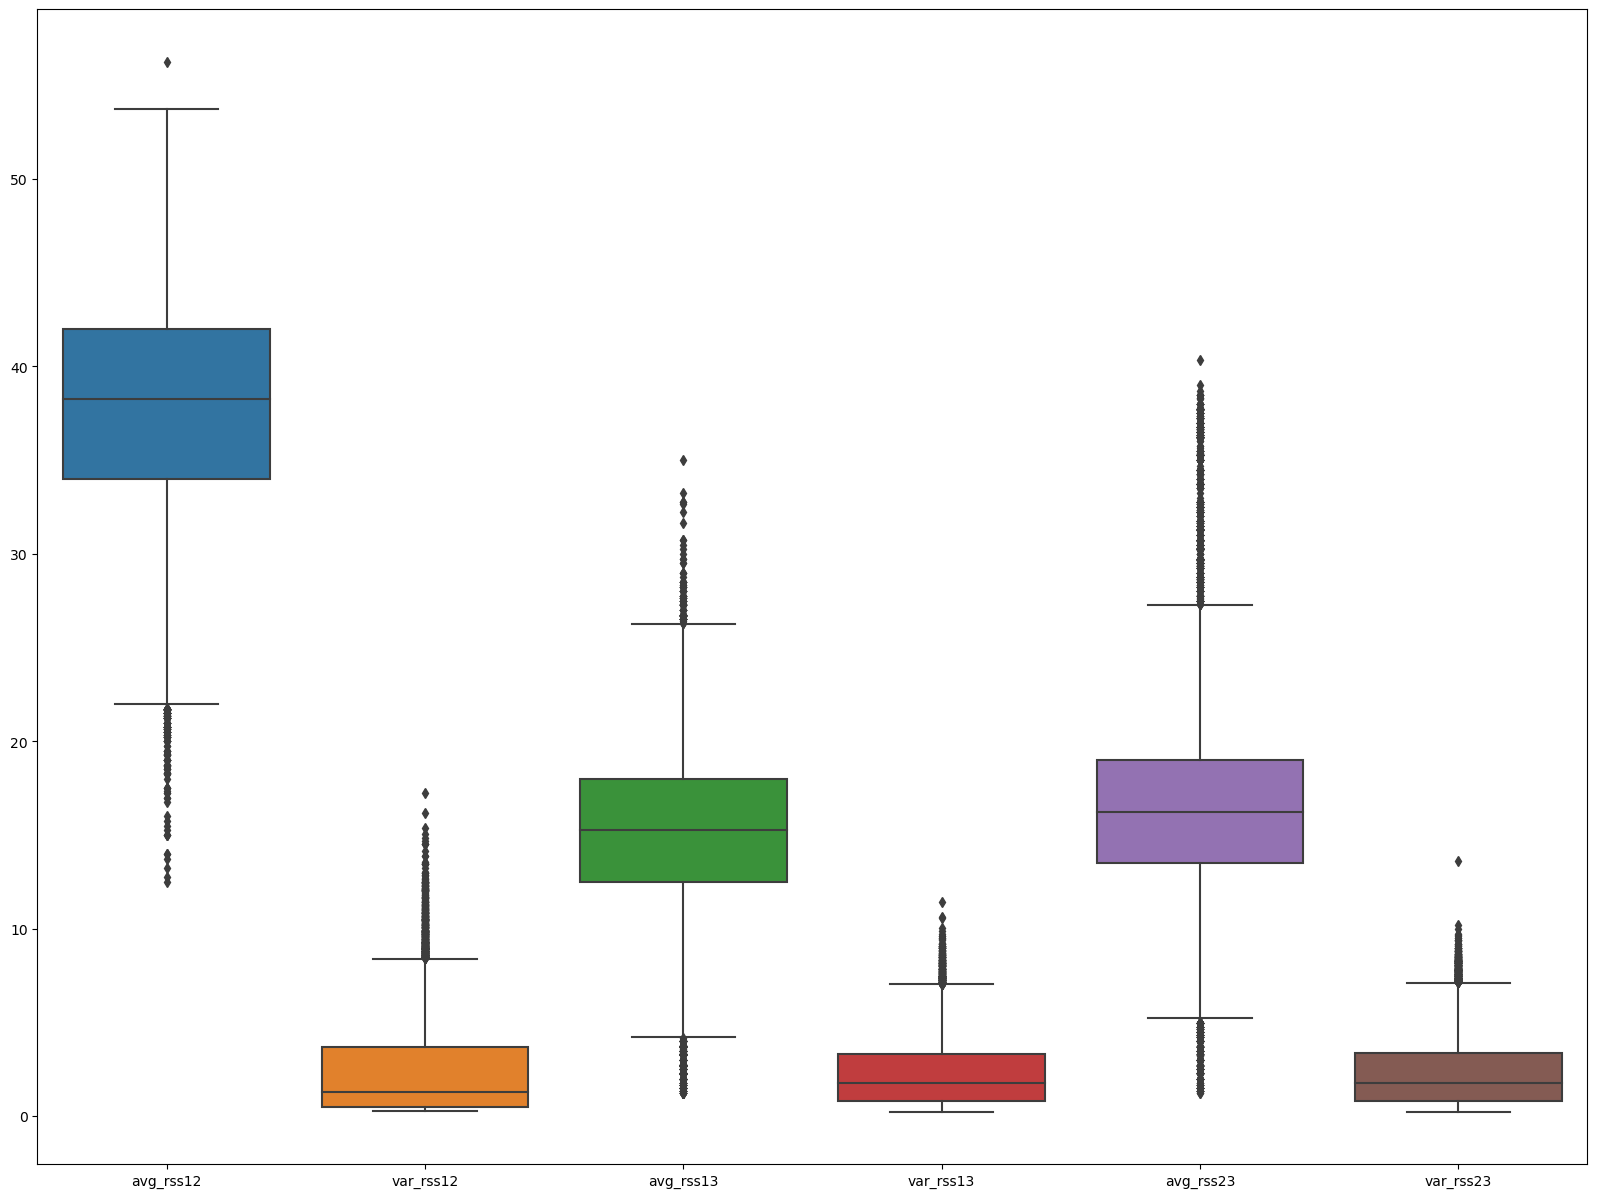

In [61]:
fig ,ax  = plt.subplots(figsize = (20,15))
sns.boxplot(data = df1.iloc[: ,1:7], ax = ax)

## Applying IQR Method to remove outliers

In [62]:
df2 = df1.copy()

In [63]:
df2.head()

,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Output
0,0,39.25,0.43,22.75,0.43,33.75,1.30,0
11,2750,39.50,0.50,23.50,0.50,32.75,0.43,0
12,3000,39.50,0.50,23.75,0.43,32.50,0.50,0
27,6750,40.50,0.50,19.75,1.09,33.75,1.30,0
30,7500,41.00,1.00,20.75,0.43,33.75,1.30,0


In [64]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21837 entries, 0 to 40794
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time       21837 non-null  int64  
 1   avg_rss12  21837 non-null  float64
 2   var_rss12  21837 non-null  float64
 3   avg_rss13  21837 non-null  float64
 4   var_rss13  21837 non-null  float64
 5   avg_rss23  21837 non-null  float64
 6   var_rss23  21837 non-null  float64
 7   Output     21837 non-null  int32  
dtypes: float64(6), int32(1), int64(1)
memory usage: 1.4 MB


In [65]:
for column in df2.columns:
    if df2[column].dtype == "float64":
        Q3,Q1 = np.nanpercentile(df2[column],[75,25])
        IQR = Q3-Q1
        LF = Q1-1.5*IQR
        HF = Q3+1.5*IQR
        
        df2[column] = np.where((df2[column] < LF) | (df2[column] > HF), np.nan, df2[column])

<Axes: >

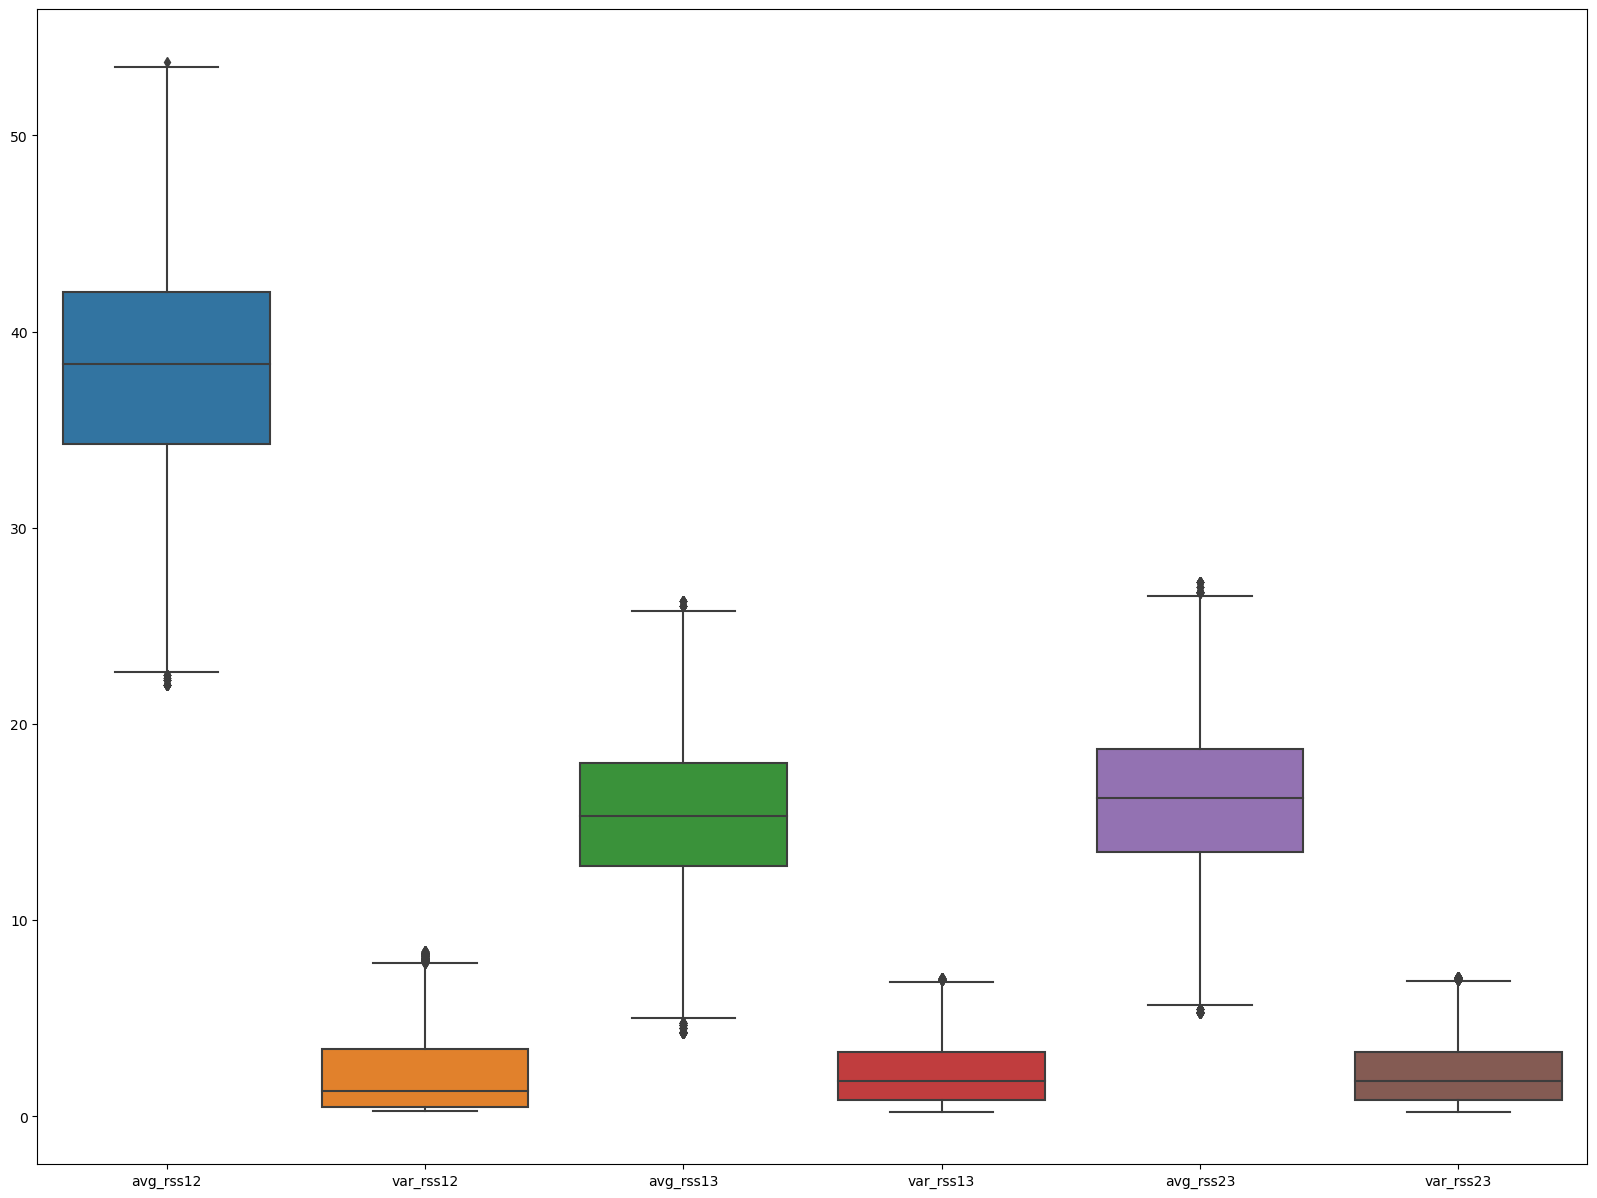

In [66]:
fig ,ax  = plt.subplots(figsize = (20,15))
sns.boxplot(data = df2.iloc[: ,1:7], ax = ax)

In [67]:
df1.shape

(21837, 8)

In [68]:
df2.shape[0]

21837

In [69]:
df2.isna().sum()[1:7].sum()/df2.shape[0]*100

13.87553235334524

If we dropped null values we will be loosing about 31% of the data.
<br>

But we will be removing them as in the end they are most likely to be mechanical errors of the sensors.

In [70]:
df2.dropna(inplace=True)

In [71]:
df2.isna().sum()

Time         0
avg_rss12    0
var_rss12    0
avg_rss13    0
var_rss13    0
avg_rss23    0
var_rss23    0
Output       0
dtype: int64

In [72]:
df2['Output'].unique()

array([0, 1, 2, 3, 4, 5, 6])

In [73]:
df2.sample(10)

,Time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Output
34531,113000,34.20,1.47,17.67,4.03,12.33,1.70,6
2602,50500,42.25,0.43,15.67,0.94,22.67,0.47,0
29337,14500,43.50,0.50,14.25,0.83,16.50,0.87,5
37691,63000,29.75,4.49,13.33,1.25,16.67,6.60,6
4273,108250,38.25,1.92,22.33,1.25,16.33,1.25,1
28733,103500,42.25,0.43,20.25,1.30,16.00,1.22,5
39458,24750,33.00,6.48,15.33,3.77,22.75,1.09,6
26468,17250,40.25,0.83,15.50,0.87,9.25,0.43,5
6292,13000,35.33,2.49,14.67,2.62,16.00,1.58,2
34459,95000,35.25,6.87,19.00,3.08,17.00,4.36,6


# Checking for an Imbalanced Dataset

In [74]:
df2.value_counts("Output")

Output
6    6212
2    5007
5    2990
4    2536
3     968
1     824
0     415
dtype: int64

In [75]:
df2["Output"] = label_encoder.inverse_transform(df2["Output"])

In [76]:
df2.value_counts("Output")

Output
walking     6212
cycling     5007
standing    2990
sitting     2536
lying        968
bending2     824
bending1     415
dtype: int64

# Feature Selection:

## Checking for Constant Features:

In [78]:
df2.columns

Index(['Time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23',
       'var_rss23', 'Output'],
      dtype='object')

In [90]:
for column in df2.columns:
    if df2[column].dtype != "object":
        variance_result = stats.variation(df2[column])
        print(f"{column}: {variance_result}")

Time: 0.5778171959147026
avg_rss12: 0.14630953004991867
var_rss12: 0.8950460514573301
avg_rss13: 0.2650413778660749
var_rss13: 0.7257240764698879
avg_rss23: 0.24536943306692424
var_rss23: 0.708997727804819


**No constant features found!**

# Standard Scaler:

In [92]:
X = df2.drop(columns = ["Output"])

In [93]:
Y = df2[["Output"]]

In [94]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaledDF = pd.DataFrame(X_scaled,columns = X.columns)

In [95]:
#ProfileReport(X_scaledDF)

# Multi-Collinearity

In [96]:
vif_values = []
for i in range(X_scaled.shape[1]):
    vif_values.append(variance_inflation_factor(X_scaled,i))
               
vif_data = pd.DataFrame({"Feature":X.columns, "vif":vif_values})

In [97]:
vif_data

,Feature,vif
0,Time,1.001420
1,avg_rss12,1.307618
2,var_rss12,1.614332
3,avg_rss13,1.109292
4,var_rss13,1.455339
5,avg_rss23,1.106215
6,var_rss23,1.491930


In [98]:
Y.sample(5)

,Output
10932,cycling
26504,standing
20093,sitting
32585,standing
30534,standing


# Handling Imbalanced Dataset:

## Over-Sampling using SMOTENC

In [99]:
label_encoder = LabelEncoder()
Y['Output'] = label_encoder.fit_transform(Y['Output'])

In [100]:
categorical_feature_name = 'Output'
categorical_feature_index = Y.columns.get_loc(categorical_feature_name)

In [101]:
categorical_feature_index

0

In [102]:
smote_nc = SMOTENC(categorical_features = [categorical_feature_index], random_state = 42)

In [103]:
X_scaled_resampled, Y_resampled = smote_nc.fit_resample(X_scaledDF,Y["Output"])

In [104]:
Y_resampled_categorical = label_encoder.inverse_transform(Y_resampled)

In [105]:
df_resampled = pd.DataFrame(X_scaled_resampled)

In [106]:
df_resampled[categorical_feature_name] = Y_resampled_categorical

In [107]:
df_resampled.shape

(43484, 8)

In [108]:
df2.shape

(18952, 8)

In [109]:
df_resampled.value_counts("Output")

Output
bending1    6212
bending2    6212
cycling     6212
lying       6212
sitting     6212
standing    6212
walking     6212
dtype: int64